# Estimators evaluation
Compare the accuracy and time required for the forecast for an increasing number of n_estimators.

**Algorithms**:
- Random forest
- XG Boost

## Preparation
- Imports
- Data preprocessing
- Feature and target encoding

In [1]:
from pandas import DataFrame
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from datetime import timedelta

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 7)

df = pd.read_csv('../0_data/DEvideos.csv',
    low_memory=False)

df['trending_date'] = df.apply(lambda row: datetime.strptime(row['trending_date'], '%y.%d.%m'), axis=1)
df['publish_time'] = df.apply(lambda row: datetime.strptime(row['publish_time'], '%Y-%m-%dT%H:%M:%S.000Z'), axis=1)
df['days_until_trending'] = df.apply(lambda row: ((row['trending_date'] - row['publish_time']).days + 1), axis=1)

df['tags_count'] = df.apply(lambda row: len(row['tags'].split('|')), axis=1)
df['publish_hour'] = df['publish_time'].map(lambda x: x.hour)
df['publish_month'] = df['publish_time'].map(lambda x: x.month)
df['publish_year'] = df['publish_time'].map(lambda x: x.year)
df['publish_day_of_month'] = df['publish_time'].map(lambda x: x.day)
df['publish_weekday'] = df['publish_time'].map(lambda x: x.weekday()) # 0: Monday, 6: Sunday

df['like_dislike_ratio'] = df.apply(lambda row: row['likes'] / (row['dislikes'] + 1), axis=1)
df['like_view_ratio'] = df.apply(lambda row: row['likes'] / (row['views'] + 1), axis=1)

df['ratings'] = df['likes'] + df['dislikes']
df['likes_per_rating'] = df.apply(lambda row: 0 if row['ratings'] == 0 else row['likes'] / row['ratings'], axis=1)
df['ratings_per_view'] = df['ratings'] / df['views']
df['comments_per_view'] = df['comment_count'] / df['views']

def assign_target_category(row):
    if row['days_until_trending'] == 0: 
        return 0
    elif row['days_until_trending'] == 1:
        return 1
    elif row['days_until_trending'] == 2:
        return 2
    elif row['days_until_trending'] <= 5:
        return 3
    else:
        return 6

df['target_category'] = df.apply(assign_target_category, axis=1)
df['channel_title'] = df['channel_title'].astype('category')

tag_df = pd.read_csv('../0_data/DEtags.csv')
tag_df = tag_df.set_index('tag')
def calculate_tag_factor(tag_string, tag_data):
    tag_list = pd.Series(list(set(map(lambda x: x.strip('\"').lower(), tag_string.split('|')))))
    return tag_list.apply(lambda tag: tag_data['factor'].get(tag, np.nan)).mean(skipna=True)
    
df['tag_factors'] = df['tags'].apply(lambda x: calculate_tag_factor(x, tag_df))
df['tag_factors'] = df.apply(lambda row: 0 if np.isnan(row['tag_factors']) else row['tag_factors'], axis=1)

N = len(df)
dropColumns = ['video_id', 'title', 'tags', 'thumbnail_link', 'description']
for column in df.columns:
    numberOfUniqueValues = df[column].nunique()
    if numberOfUniqueValues < 2:
        dropColumns.append(column)
    elif df[column].dtype == 'object' and numberOfUniqueValues > N * 0.9:
        dropColumns.append(column)
    elif df[column].isna().sum() / N > 0.95:
        dropColumns.append(column)
        
df.drop(columns=dropColumns, inplace=True)

x_df = DataFrame(index=df.index)
features = ['views', 'publish_hour', 'ratings_per_view', 'comments_per_view', 'tag_factors']
for feature in features:
    feature_data = df[feature]
    if df[feature].dtype.name == 'category':
        x_label_encoder = preprocessing.LabelEncoder()
        x_label_encoder.fit(feature_data.astype(str))
        x_df[feature] = x_label_encoder.transform(feature_data)
    elif df[feature].dtype.name == 'datetime64[ns]':
        x_df[feature] = feature_data.to_seconds()
    elif df[feature].dtype.name == 'bool':
        x_df[feature] = int(feature_data)
    else:
        x_df[feature] = feature_data

x = np.reshape(x_df, (-1, len(x_df.columns)))

target = df['target_category'].astype(str)
y_label_encoder = preprocessing.LabelEncoder()
y_label_encoder.fit(target)
y = y_label_encoder.transform(target)

## Calculation of the influences on the algorithms
Different numbers of estimators are tested for each algorithm and the resulting accuracy and calculation time are saved for the evaluation.

### Random Forest

In [2]:
%%time
rf_model = RandomForestClassifier()
optimization_dict = {'n_estimators': [5, 10, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 250, 500, 750, 1000]}

model_rf = GridSearchCV(rf_model, optimization_dict, scoring='accuracy', n_jobs=-1)

model_rf.fit(x,y)
print(model_rf.best_score_)
print(model_rf.best_params_)

0.6889569049951029
{'n_estimators': 750}
Wall time: 2min 40s


In [3]:
results_rf = pd.DataFrame()
results_rf['mean_fit_time'] = model_rf.cv_results_.get('mean_fit_time')
results_rf['mean_score_time'] = model_rf.cv_results_.get('mean_score_time')
results_rf['params'] = model_rf.cv_results_.get('params')
results_rf['mean_test_score'] = model_rf.cv_results_.get('mean_test_score')
results_rf['rank_test_score'] = model_rf.cv_results_.get('rank_test_score')
results_rf['algorithm'] = 'random_forest'

### XG Boost

In [4]:
%%time
xgb_model = XGBClassifier(use_label_encoder=False, verbosity=0)
optimization_dict = {'n_estimators': [5, 10, 20, 40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200, 500, 1000]}

model_xgb = GridSearchCV(xgb_model, optimization_dict, scoring='accuracy', n_jobs=-1)

model_xgb.fit(x,y)
print(model_xgb.best_score_)
print(model_xgb.best_params_)

0.6789911851126347
{'n_estimators': 70}
Wall time: 3min 33s


In [5]:
results_xgb = pd.DataFrame()
results_xgb['mean_fit_time'] = model_xgb.cv_results_.get('mean_fit_time')
results_xgb['mean_score_time'] = model_xgb.cv_results_.get('mean_score_time')
results_xgb['params'] = model_xgb.cv_results_.get('params')
results_xgb['mean_test_score'] = model_xgb.cv_results_.get('mean_test_score')
results_xgb['rank_test_score'] = model_xgb.cv_results_.get('rank_test_score')
results_xgb['algorithm'] = 'xg_boost'

## Evaluation
Evaluation of the results in several visualizations.

Merging the results.

In [6]:
results = results_rf.append(results_xgb)
results['total_time'] = (results['mean_fit_time'] + results['mean_score_time'])
results['n_estimators'] = results.apply(lambda row: row['params'].get('n_estimators'), axis=1)
results.head(15)

,mean_fit_time,mean_score_time,params,mean_test_score,rank_test_score,algorithm,total_time,n_estimators
0,0.399596,0.013402,{'n_estimators': 5},0.653232,16,random_forest,0.412998,5
1,0.769797,0.024999,{'n_estimators': 10},0.667458,15,random_forest,0.794797,10
2,1.591196,0.045400,{'n_estimators': 20},0.677179,14,random_forest,1.636596,20
3,3.157601,0.087399,{'n_estimators': 40},0.681244,13,random_forest,3.245000,40
4,4.539799,0.129401,{'n_estimators': 60},0.685627,11,random_forest,4.669200,60
5,6.061801,0.175198,{'n_estimators': 80},0.685725,10,random_forest,6.236999,80
6,7.511198,0.212202,{'n_estimators': 100},0.686631,9,random_forest,7.723400,100
7,8.816401,0.255798,{'n_estimators': 120},0.685137,12,random_forest,9.072199,120
8,10.374999,0.300601,{'n_estimators': 140},0.688516,3,random_forest,10.675599,140
9,11.912200,0.347400,{'n_estimators': 160},0.686802,8,random_forest,12.259599,160


### Random forest
The optimal number of estimators for the random forest algorithm for the given data and feature set is 140. The results do not improve with a higher number, while the execution time increases consistently linearly. However, the quality of the results does not decrease with a higher number of estimators.

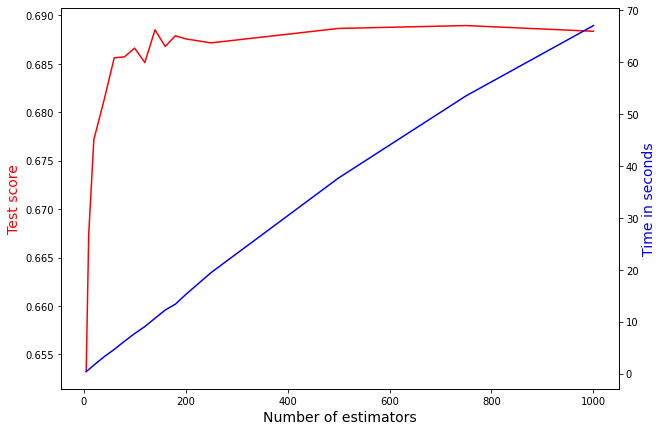

In [7]:
results_rf = results[results['algorithm'] == 'random_forest']

fig,ax = plt.subplots()
ax.plot(results_rf.n_estimators, results_rf.mean_test_score, color="red")
ax.set_xlabel("Number of estimators", fontsize=14)
ax.set_ylabel("Test score", color="red", fontsize=14)

ax2=ax.twinx()
ax2.plot(results_rf.n_estimators, results_rf.total_time, color="blue")
ax2.set_ylabel("Time in seconds", color="blue", fontsize=14)

plt.show()

At this point, the section in which the accuracy changes to stagnation is shown again in more detail.

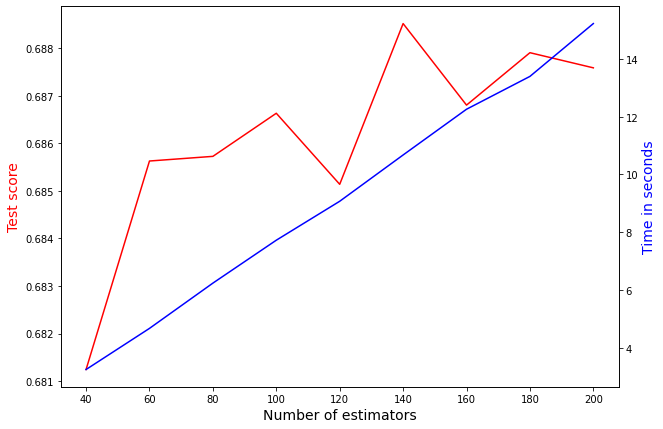

In [8]:
results_rf_gain = results_rf[(results_rf['n_estimators'] >= 25) & (results_rf['n_estimators'] <= 200)]

fig,ax = plt.subplots()
ax.plot(results_rf_gain.n_estimators, results_rf_gain.mean_test_score, color="red")
ax.set_xlabel("Number of estimators", fontsize=14)
ax.set_ylabel("Test score", color="red", fontsize=14)

ax2=ax.twinx()
ax2.plot(results_rf_gain.n_estimators, results_rf_gain.total_time, color="blue")
ax2.set_ylabel("Time in seconds", color="blue", fontsize=14)

plt.show()

### XG Boost
The optimal number of estimators for the XG Boost algorithm for the given data and feature set is 70. The results worsen significantly with a higher number, while the time required continues to increase sharply, albeit slightly flattening.

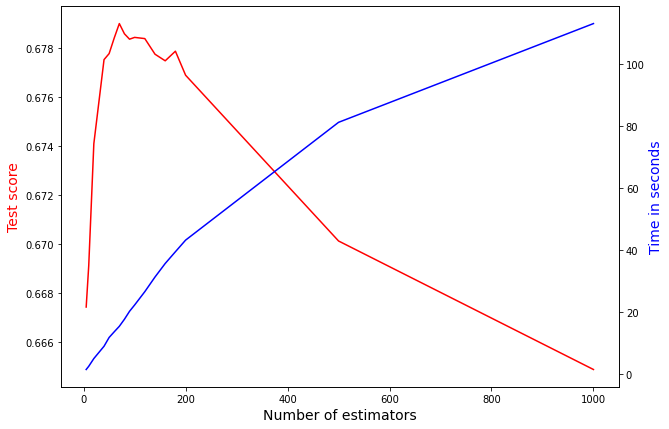

In [9]:
results_xgb = results[results['algorithm'] == 'xg_boost']

fig,ax = plt.subplots()
ax.plot(results_xgb.n_estimators, results_xgb.mean_test_score, color="red")
ax.set_xlabel("Number of estimators", fontsize=14)
ax.set_ylabel("Test score", color="red", fontsize=14)

ax2=ax.twinx()
ax2.plot(results_xgb.n_estimators, results_xgb.total_time, color="blue")
ax2.set_ylabel("Time in seconds", color="blue", fontsize=14)

plt.show()

At this point the high point is shown in more detail.

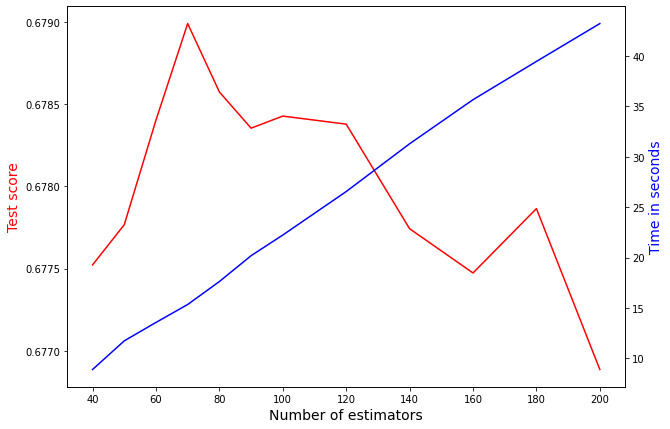

In [10]:
results_xgb_top = results_xgb[results_xgb['mean_test_score'] > 0.675]

fig,ax = plt.subplots()
ax.plot(results_xgb_top.n_estimators, results_xgb_top.mean_test_score, color="red")
ax.set_xlabel("Number of estimators", fontsize=14)
ax.set_ylabel("Test score", color="red", fontsize=14)

ax2=ax.twinx()
ax2.plot(results_xgb_top.n_estimators, results_xgb_top.total_time, color="blue")
ax2.set_ylabel("Time in seconds", color="blue", fontsize=14)
 
plt.show()

### Comparison accuracy
At this point, the accuracy of the individual algorithms is put into a common context.

<AxesSubplot:xlabel='n_estimators', ylabel='mean_test_score'>

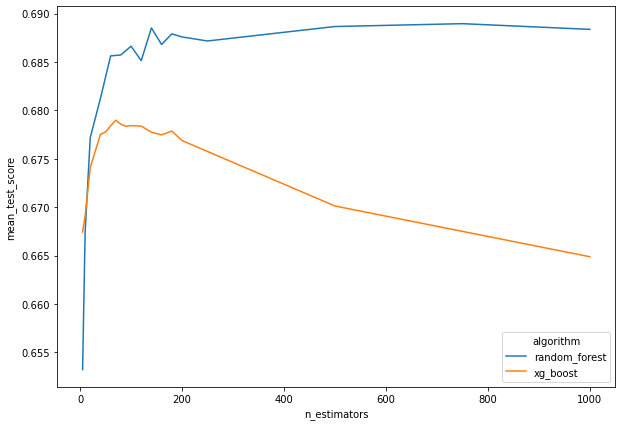

In [11]:
sns.lineplot(data=results, x='n_estimators', y='mean_test_score', hue='algorithm')

### Comparison execution time
At this point, the execution time of the individual algorithms is put into a common context.

<AxesSubplot:xlabel='n_estimators', ylabel='total_time'>

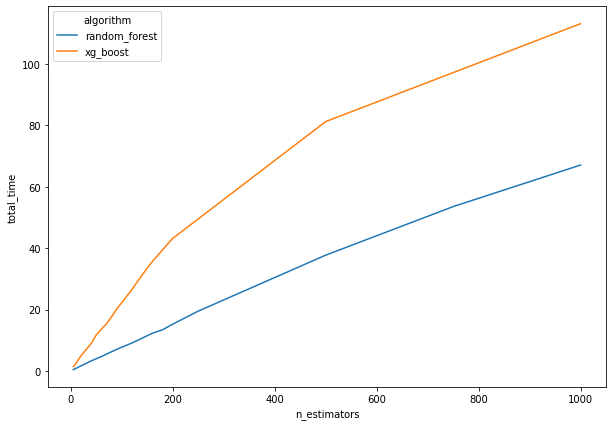

In [12]:
sns.lineplot(data=results, x='n_estimators', y='total_time', hue='algorithm')